# Demo of pytikz, a Python interface to Ti*k*Z

The import package is called `tikz`. For interactive use, importing the contents into the current namespace is more convenient.

In [1]:
# %#load_ext autoreload
# %#autoreload 2

from itertools import chain
import matplotlib.pyplot as plt

import tikz
from tikz import *


def opts(*iterable, **kwargs):
    return ",".join(chain(iterable, (f"{k}={v}" for k, v in kwargs.items())))


def coor_remove_bkt(text):
    text = tikz._coordinate(text)
    if isinstance(text, np.ndarray):
        text = tuple(text)
    text = str(text).strip()
    if text[0] == "(" and text[-1] == ")":
        text = text[1:-1]
    return text


def from_some_distance_away(pt_origin, pt_ref, distance="5mm", angle=-90):
    return f"(${pt_origin}!{distance}!{angle}:{pt_ref}$)"


def prepare_pic():
    pic = Picture()
    pic.usetikzlibrary("calc,shapes.geometric")

    # circle
    pic.usetikzlibrary("angles,quotes")

    # pic = Picture(scale=3, line_cap="round")
    pic.usepackage(r"tikz-dimline")

    pic.tikzset(
        r"""dot/.style={circle,fill=blue,minimum size=3pt, inner sep=0pt},
             square/.style={rectangle,fill=red,minimum size=4pt, inner sep=0pt,%    
                        rotate=30,anchor=center},%
            mytext/.style={anchor=north,text width=3cm,align=center}"""
    )
    return pic


def dimline(content, pt1, pt2, extension_length="5mm", opt=None, flip: bool = False):
    if opt is None:
        opt = []
    opt.append(f"extension start length={extension_length}")
    opt.append(f"extension end length={extension_length}")

    flip_sign = -1 if flip else 1

    dimline_pt1 = from_some_distance_away(pt1, pt2, angle=flip_sign * 90)
    dimline_pt2 = from_some_distance_away(pt2, pt1, angle=flip_sign * (-90))

    def wrap_b(text):
        return "{" + str(text) + "}"

    return rf"\dimline[{','.join(opt)}] {wrap_b(dimline_pt1)}{wrap_b(dimline_pt2)}{wrap_b(content)}"


def define_right_angle_drawing(pic):
    # right angle drawing
    pic.tikzset(
        r"""
        right angle quadrant/.code={
            \pgfmathsetmacro\quadranta{{1,1,-1,-1}[#1-1]}     % Arrays for selecting quadrant
            \pgfmathsetmacro\quadrantb{{1,-1,-1,1}[#1-1]}},
        right angle quadrant=1, % Make sure it is set, even if not called explicitly
        right angle length/.code={\def\rightanglelength{#1}},   % Length of symbol
        right angle length=2ex, % Make sure it is set...
        right angle symbol/.style n args={3}{
            insert path={
                let \p0 = ($(#1)!(#3)!(#2)$),     % Intersection
                    \p1 = ($(\p0)!\quadranta*\rightanglelength!(#3)$), % Point on base line
                    \p2 = ($(\p0)!\quadrantb*\rightanglelength!(#2)$), % Point on perpendicular line
                    \p3 = ($(\p1)+(\p2)-(\p0)$) in  % Corner point of symbol
                (\p1) -- (\p3) -- (\p2)
            }
        }
        """
    )


def draw_right_angle(pic, line_pt1, line_pt2, pt3, raq=2):
    """
        \ (line_pt1)
         \
          \
     .     \ (line_pt2)
    (pt3)
    """
    return pic.draw(
        rf"(${line_pt1}!{line_pt2}!{pt3}$)",
        opt=opts(
            rf"right angle quadrant={raq}",
            rf"right angle length=2mm",
            rf"right angle symbol="
            rf"{{{coor_remove_bkt(line_pt1)}}}"
            rf"{{{coor_remove_bkt(line_pt2)}}}"
            rf"{{{coor_remove_bkt(pt3)}}}",
        ),
    )


def pt_of_intersect(line_pt1, line_pt2, pt3):
    return rf"($({coor_remove_bkt(line_pt1)})!({coor_remove_bkt(line_pt2)})!({coor_remove_bkt(pt3)})$)"


pt_of_intersect((0, 1), (1, 2), np.array([1, 2]))

'($(0, 1)!(1, 2)!(1, 2)$)'

## Using `Picture` objects to create graphics

Example graphic from the manual, [Part I](https://pgf-tikz.github.io/pgf/pgfmanual.pdf#part.1)

Creating a graphic always involves creating a `Picture` object and performing operations on it. Here, the `draw()` method accepts a path specification (determines what to draw) as well as options (determine how to draw).

In [2]:
# define coordinates as a list of tuples
coords = [(0, 0), (0, 2), (1, 3.25), (2, 2), (2, 0), (0, 2), (2, 2), (0, 0), (2, 0)]

# create `Picture` object
pic = Picture()
# draw a line following the coordinates
pic.draw(line(coords), thick=True, rounded_corners="4pt")

Evaluating the `Picture` object in the notebook renders the graphic as a PNG and embeds it in the notebook.

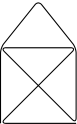

In [3]:
pic

The method `code()` returns the LaTeX/TikZ code of the `Picture` object, which is a `tikzpicture` environment. The same method is present on all objects that represent parts of the graphics. Notice how the structure of the Python code mimics that of the TikZ code.

In [4]:
print(pic.code())

\begin{tikzpicture}
\draw[thick,rounded corners=4pt] (0,0) -- (0,2) -- (1,3.25) -- (2,2) -- (2,0) -- (0,2) -- (2,2) -- (0,0) -- (2,0);
\end{tikzpicture}


The method `demo()` of a `Picture` object shows both the rendered graphic and the underlying code in the notebook. It takes an optional argument `dpi` to specify the rendering resolution. It is intended to be used during development and debugging of a picture.


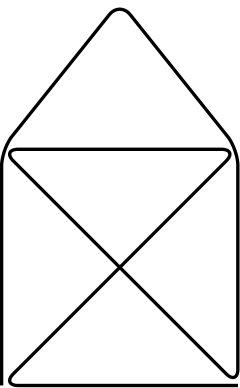

In [5]:
pic.demo(dpi=300)

The method `document_code()` of a `Picture` object returns the complete LaTeX/TikZ code used to render the graphic. When a graphic is rendered, internally this code is written to a temporary file and compiled with (pdf/Xe/Lua) LaTeX. The resulting PDF is read and can be either saved (using the method `write_image()`) or rastered for display in the notebook. A rastered version can also be saved.

## A picture for Karl's students

Based on the code developed in the first tutorial of the manual, [§2](https://pgf-tikz.github.io/pgf/pgfmanual.pdf#section.2).


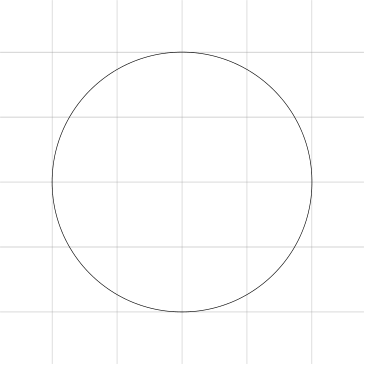

In [6]:
pic = Picture(scale=3, line_cap="round")

## define styles
pic.style("important line", very_thick=True)

# define colors
pic.colorlet("anglecolor", "green!50!black")
pic.colorlet("sincolor", "red")
pic.colorlet("coscolor", "blue")
pic.colorlet("tancolor", "orange!80!black")

# background grid
pic.draw((-1.4, -1.4), grid((1.4, 1.4), step="0.5cm"), help_lines=True, very_thin=True)

# circle
pic.draw((0, 0), circle(radius=1))

pic.demo(dpi=110)


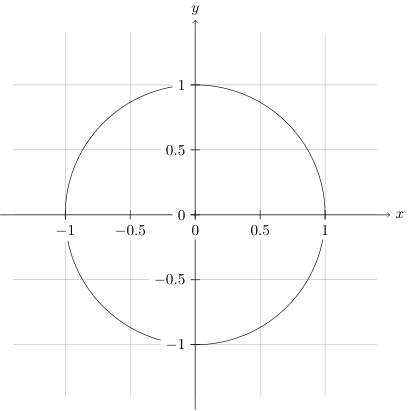

In [7]:
# `scope` environment to contain the axes code
scope = pic.scope()

# horizontal axis and label
scope.draw(
    (-1.5, 0),
    lineto((1.5, 0)),
    node("$x$", right=True),
    coordinate(name="x axis"),
    opt="->",
)

# vertical axis and label
scope.draw(
    (0, -1.5),
    lineto((0, 1.5)),
    node("$y$", above=True),
    coordinate(name="y axis"),
    opt="->",
)

# ticks and tick labels on horizontal axis
for x in [-1, -0.5, 0, 0.5, 1]:
    scope.draw(
        "(0pt,1pt)",
        lineto("(0pt,-1pt)"),
        node(f"${x}$", below=True, fill="white"),
        xshift=f"{x} cm",
    )

# ticks and tick labels on vertical axis
for y in [-1, -0.5, 0, 0.5, 1]:
    scope.draw(
        "(1pt,0pt)",
        lineto("(-1pt,0pt)"),
        node(f"${y}$", left=True, fill="white"),
        yshift=f"{y} cm",
    )

pic.demo(dpi=110)


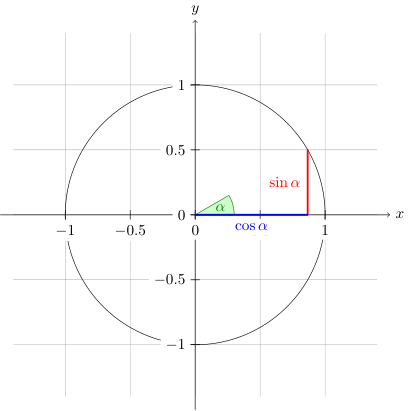

In [8]:
# angle of 30 degrees
pic.path(
    (0, 0),
    lineto("(3mm,0mm)"),
    arc(start_angle=0, end_angle=30, radius="3mm"),
    "--cycle",
    fill="green!20",
    draw="anglecolor",
)
# label for angle
pic.draw("(15:2mm)", node(r"$\alpha$", anglecolor=True))

# sine line and label
pic.draw(
    "(30:1cm)",
    lineto("(30:1cm |- x axis)"),
    node(r"$\sin \alpha$", left="1pt", fill="white", pos=0.5),
    important_line=True,
    sincolor=True,
)

# cosine line and label
pic.draw(
    "(30:1cm |- x axis)",
    lineto((0, 0)),
    node(r"$\cos \alpha$", below="2pt", fill="white", pos=0.5),
    important_line=True,
    coscolor=True,
)

pic.demo(dpi=110)


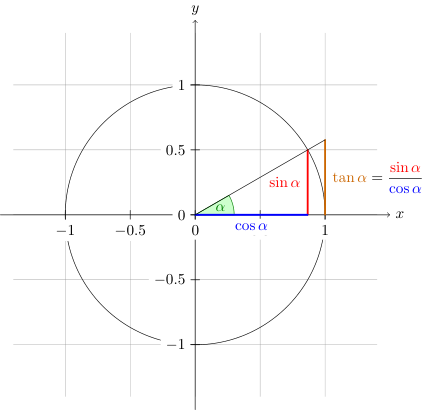

In [9]:
# To determine the top of the tangent line, the intersection of a line at 30 degrees from the origin with a line upwards from (1, 0) is determined
pic.usetikzlibrary("intersections")
pic.path((1, 0), lineto((1, 1)), name_path="upward line")
pic.path((0, 0), lineto("(30:1.5)"), name_path="sloped line")
pic.draw(name_intersections="{of=upward line and sloped line, by=t}")

# tangent line and label
pic.draw(
    (1, 0),
    lineto("(t)"),
    node(
        r"""$
            \displaystyle
            \tan \alpha
            \color{black} = \frac{
                \color{red} \sin \alpha}{
                \color{blue} \cos \alpha}
            $""",
        right="1pt",
        fill="white",
        pos=0.5,
    ),
    tancolor=True,
    very_thick=True,
)

# line from the origin to the top of the tangent line
pic.draw((0, 0), lineto("(t)"))

pic.demo(dpi=110)

In [ ]:
pic